## CS4120 Project
## Evaluating Smoothing of Various Ngram Language Models for Joke Generation

#### Team: Daniel Pickett

#### Summary
This project will attempt to approach the problem of humour in NLP and construct various language models trained on a dataset of jokes and then performing sentence generation and evaluating the results. To determine which jokes are funny or not is subjective and makes evaluating these generated sentences difficult. In the past many papers use hand labeled examples for 'funny' and 'unfunny' jokes. Given a dataset for over 200,000 jokes, this wouldn't be possible. This project will approach this task by using the reddit scores to make this classification.

Each joke in the dataset recieves a score from users on the site. Each user can contribute +1 or -1 to the score. In this project first a classifier is constructed using tfidf vectors to distinguish between good and bad or 'funny' and 'unfunny' jokes, by binning jokes that have recieved over 20 score and under 20 score. This classifier has around 63% accuracy testing on around 15,000 jokes.

Then ngram models are constructed using three types of smoothing: Laplace, 

### Instructions

The following packages (in the import statements) of NLTK language models, NLTK stopwords dataset, and sklearn are required. Any missing packages can be installed using pip. As long as the packages are installed the notebook is able to be run sequentially. There are a few cells such as training a Logistic Regression model, and generating thousands of sentences, which can sometimes take upwards of 30 minutes to run. However, the sentences generated are also downloaded to text files and included in the submission.

In [52]:
import json
import contractions
import pandas as pd
import numpy as np
import nltk
import pickle
import random

import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.util import bigrams
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.tokenize.treebank import TreebankWordTokenizer
from nltk.lm.preprocessing import pad_both_ends
from nltk.lm.preprocessing import flatten
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.lm import StupidBackoff
from nltk.lm import Laplace
from nltk.lm import AbsoluteDiscountingInterpolated

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### 1. Dataset

The dataset being used is from the provided list of datasets given to the class. It can be found at the following link https://github.com/taivop/joke-dataset as the file reddit_jokes.json. This github repository contains a variety of joke datasets within it, but I will be focusing only on the Reddit jokes as they each have an associated score, which will be used to infer which jokes are recieved well and which are recieved poorly, and to construct a classifier. Each of the entries in the json is a single post to reddit.com/r/jokes where each post is a single english joke. The text of the each posts consists of a title and a body which will be concatenated to form the joke.

#### Read in and tokenize jokes and corresponding score

In [2]:
f = open('reddit_jokes.json', 'r')
data = json.load(f)
f.close()
ex_count = len(data)
print(ex_count)
data[1005]

194553


{'body': 'A gummy bear',
 'id': '5tdpho',
 'score': 11,
 'title': 'What do you call a bear with no teeth'}

The text of each joke is processed by converting to lowercase, then tokenized using TreebankWordTokenizer. TreebankWordTokenizer was chosen as it has a correspanding detokenizer to completely reverse the operation and turn a set of tokens back into a sentence. This tokenizer (https://www.nltk.org/_modules/nltk/tokenize/treebank.html) splits standard contractions and also seperates off punctuation and quotations.

In [3]:
# to build the classifier, construct a list of examples and labels
X = []
y = []
tokenizer = TreebankWordTokenizer()
# https://www.nltk.org/_modules/nltk/tokenize/treebank.html

print('Pre-processing Text')

for i, post in enumerate(data):
    text = post['title'] + ' ' + post['body']
    # pre-processing: lowercase, expand contractions, NLTK tokenize, add start and end tokens
    text = text.lower()
    text = TreebankWordTokenizer().tokenize(text)
    text = ['<s>'] + text + ['</s>']
    
    # display progress
    if i != 0 and (i+1) % 10_000 == 0 or (i+1) == ex_count:
        print(i+1, '/', ex_count)
    
    score = post['score']
    X.append(text)
    y.append(score)

Pre-processing Text
10000 / 194553
20000 / 194553
30000 / 194553
40000 / 194553
50000 / 194553
60000 / 194553
70000 / 194553
80000 / 194553
90000 / 194553
100000 / 194553
110000 / 194553
120000 / 194553
130000 / 194553
140000 / 194553
150000 / 194553
160000 / 194553
170000 / 194553
180000 / 194553
190000 / 194553
194553 / 194553


### 2. Construct a Classifier to Evaluate Jokes

The following cells will bin the target variable (the jokes score) into two classes representing a good (1) and bad (0) joke.

The boundary selected for the cutoff of these bins is that a total score of over 20 constitutes a funny joke. The score is a sum of the upvotes and downvotes so to achieve a score of more than 20 requires a significant number of different people voting that they liked this joke and it has recieved an overall postive response. Since 50% of the dataset contains jokes with 3 or less score, undersampling will be used to balance the data so that the classifier doesn't simply predict the majority class, but instead learns patterns of words found in the popular jokes.


There are 44373 examples at or over 20 upvotes and 150180 under 20 upvotes.

In [4]:
jokes_df = pd.DataFrame(list(zip(X, y)), columns=['text', 'score'])
jokes_df['score'] = pd.cut(
    jokes_df['score'],bins=[-1, 20, 50_000], labels=[0, 1])

print('1:', len(jokes_df[jokes_df['score'] == 1]))
print('0:', len(jokes_df[jokes_df['score'] == 0]))

1: 43431
0: 151122


In [5]:
shuffled_df = jokes_df.sample(frac=1, random_state=0)
good_jokes_df = shuffled_df[shuffled_df['score'] == 1]

# undersample, take only 43,431/151,122 from negative class
bad_jokes_df = shuffled_df[shuffled_df['score'] == 0].sample(n=43_431)

balanced_df = pd.concat([good_jokes_df, bad_jokes_df])
balanced_df = balanced_df.reset_index(drop=True)

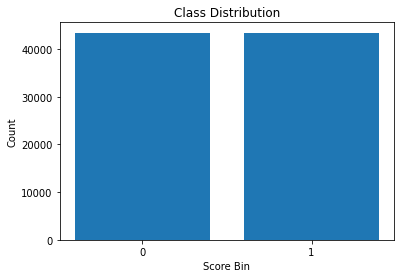

In [6]:
# plot the class distribution
labels, counts = np.unique(balanced_df['score'], return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.title('Class Distribution')
plt.xlabel('Score Bin')
plt.ylabel('Count')
plt.show()

In [7]:
# Save new balanced data
X = list(balanced_df['text'])
y = list(balanced_df['score'])

#### Data Exploration

In [8]:
# random tokenized example of 'good' >20 upvotes joke
# to show tokenization
y[12], X[12]

(1,
 ['<s>',
  'what',
  'did',
  'the',
  'amputee',
  'say',
  'to',
  'his',
  'mom',
  'when',
  'he',
  'learned',
  'to',
  'ride',
  'a',
  'bike',
  '?',
  'look',
  'ma',
  ',',
  'no',
  'hands',
  '!',
  '</s>'])

In [10]:
# show some metrics on the data
joke_word_counts = [len(ex) for ex in X]

avg_words = np.mean(joke_word_counts)
longest_joke = X[np.argmax(joke_word_counts)], y[np.argmax(joke_word_counts)]
shortest_joke = X[np.argmin(joke_word_counts)], y[np.argmin(joke_word_counts)]

print('Jokes', '-' * 20)
print('Number of examples:\t', ex_count)
print('Average word count:\t', np.round(avg_words, 2))
print('Longest example:\t', np.max([len(ex) for ex in X]))
print('\tscore:', longest_joke[1], longest_joke[0][:10], '...\n')

print('Shortest example:\t', np.min([len(ex) for ex in X]))
print('\tscore:', shortest_joke[1], shortest_joke[0])

print('\nScores', '-' * 20)
print('Max score:', np.max(y))
print('Min score:', np.min(y))
print('Average score:', np.round(np.mean(y), 2))

Jokes --------------------
Number of examples:	 194553
Average word count:	 66.18
Longest example:	 8810
	score: 1 ['<s>', 'lost', 'in', 'the', 'desert.', 'so', ',', 'there', "'s", 'a'] ...

Shortest example:	 3
	score: 1 ['<s>', 'congress', '</s>']

Scores --------------------
Max score: 1
Min score: 0
Average score: 0.5


#### Split Data for Classifier and Language Models

Split examples into multiple sets: 60% for evaluation classifier, 40% for the language models.

The language models should not train on the same training data that the model they are being evaluated by was trained from.

In [11]:
X_classifier, X_lm, y_classifier, y_lm = train_test_split(
    X, y, test_size=0.4, random_state=0)

In [12]:
# first detokenize examples, tokenizing then detokenizing will remove many uneccsary characters
# such as new lines and spaces
X_detoken = [TreebankWordDetokenizer().detokenize(x) for x in X_classifier]

#### Vectorize Training Data

In [13]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/daniel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

To break each joke into a vector to be trained by the classifier, tfidf (term frequency–inverse document frequency) is used to vectorize the jokes and find specific tokens that are most important to the funny jokes and weight them highly, while assigning low weights to words that don't often appear in these good jokes. The tfidf vectorizer will consider both unigrams and bigrams, and will filter out any stop words from the NLTK stopwords dataset.

The training data for the classifier is split again into 70% training and 30% testing, to ensure that the model is able to generalize and will be effective in the end at classifying the unseen generated sentences from the language models.

In [14]:
tfidf = TfidfVectorizer(
    sublinear_tf=True, min_df=5, norm='l2', 
    encoding='latin-1', ngram_range=(1, 2), stop_words='english')

X_tf = tfidf.fit_transform(X_detoken).toarray()

# of classifier(70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_tf, y_classifier, test_size=0.3, random_state=0)

In [199]:
# display some features of the tfidf
features_names = tfidf.get_feature_names()
print(random.sample(features_names ,10))
X_tf.shape

['russian responds', 'anniversary wife', 'walks slowly', 'got taste', 'possibility', 'heard voice', 'cardboard boxes', 'outside sees', 'silly said', 'walrus']


(52117, 47206)

In [201]:
# combine features and their corresponding scores and sort them to find best and worst features
# takes ~3 minutes
scores = zip(tfidf.get_feature_names(), np.asarray(X_tf.sum(axis=0)).ravel())
sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)

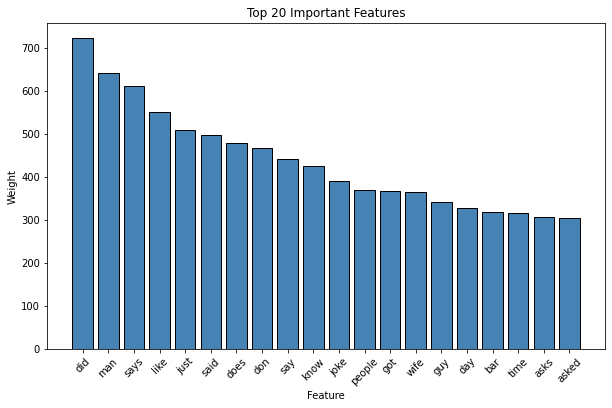

In [311]:
# top 20 best features for popular jokes
plt.figure(figsize=(10, 6))
plt.xticks(rotation = 45)
plt.title('Top 20 Important Features')
plt.ylabel('Weight')
plt.xlabel('Feature')
for i in range(20):
    plt.bar(sorted_scores[i][0], sorted_scores[i][1], color='steelblue', edgecolor='black')
plt.show()

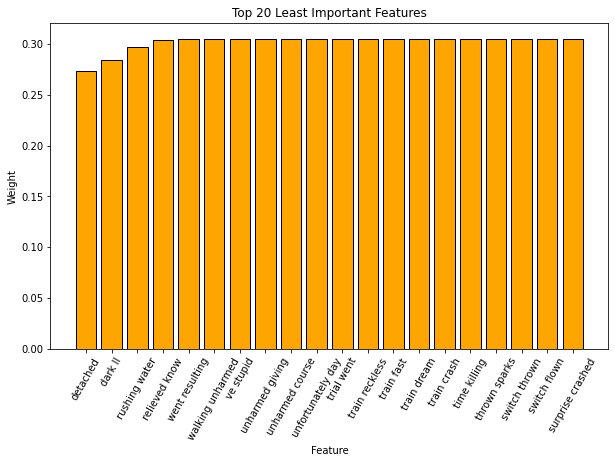

In [312]:
# worst 20 feautres for popular jokes
plt.figure(figsize=(10, 6))
plt.title('Top 20 Least Important Features')
plt.ylabel('Weight')
plt.xlabel('Feature')
plt.xticks(rotation = 60)
for i in range(len(sorted_scores)-1, len(sorted_scores)-21, -1):
    plt.bar(sorted_scores[i][0], sorted_scores[i][1], color='orange',edgecolor='black')
plt.show()

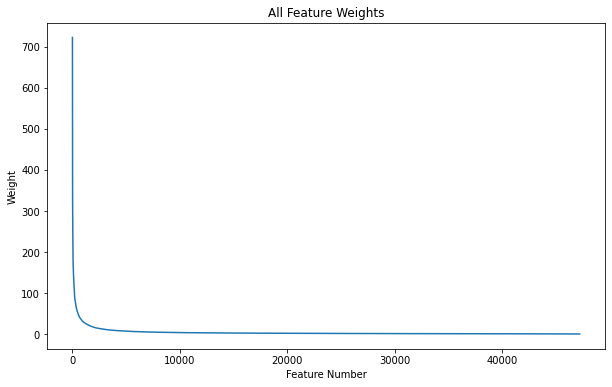

In [313]:
lbls, scrs = zip(*sorted_scores)
plt.figure(figsize=(10, 6))
plt.title('All Feature Weights')
plt.ylabel('Weight')
plt.xlabel('Feature Number')
plt.plot(scrs)
plt.show()

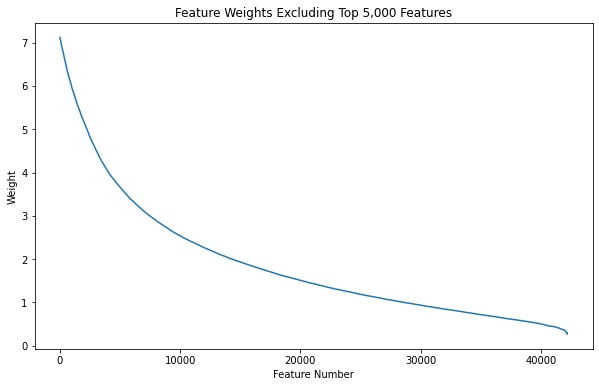

In [321]:
# feature importance over time
lbls, scrs = zip(*sorted_scores)
plt.figure(figsize=(10, 6))
plt.title('Feature Weights Excluding Top 5,000 Features')
plt.ylabel('Weight')
plt.xlabel('Feature Number')
plt.plot(scrs[5_000:])
plt.show()

#### Train Evaluation Model

In [15]:
# instead of running this cell the model can be loaded from the provided file in cell below
# takes ~5-10 minutes to train
lr = LogisticRegression(random_state=0)
lr.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [323]:
#pickle.dump(lr, open('LogisticRegressionModel.sav', 'wb')) # used to save the model, commented as already saved
lr = pickle.load(open('LogisticRegressionModel.sav', 'rb')) # can be used to load the model, avoiding training

In [324]:
# predict test and training examples to calculate performance metrics
# of this classifier on testing and training examples
y_test_predict = lr.predict(X_test)
y_train_predict = lr.predict(X_train)

In [325]:
def print_scores(true, predicted):
    '''Prints the accruacy, precision, recall, and f1 score. given true labels and predicted labels.'''
    acc = accuracy_score(true, predicted)
    prec = precision_score(true, predicted, average='macro')
    rec = recall_score(true, predicted, average='macro')
    f1 = f1_score(true, predicted,average='macro')
    print('Accuracy', acc)
    print('Precision', prec)
    print('Recall', rec)
    print('F1 Score', f1)

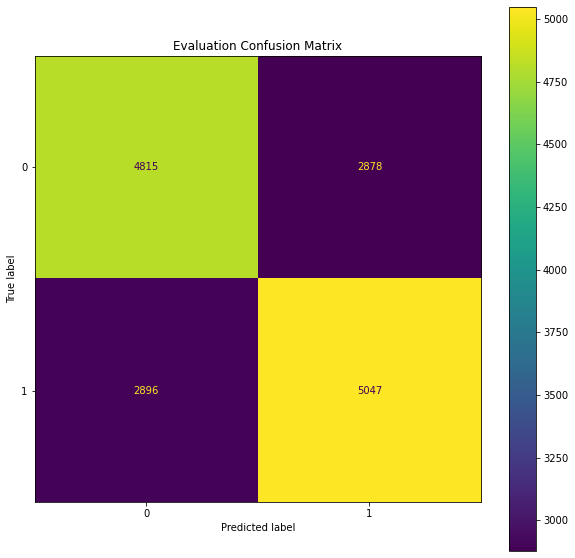

Training Scores
Accuracy 0.7777747320523012
Precision 0.7778275625509133
Recall 0.7778112538882804
F1 Score 0.7777739138557425
----
Testing Scores
Accuracy 0.6307239703248912
Precision 0.6306390272898685
Recall 0.630647955268314
F1 Score 0.63064265519018


In [326]:
fig, ax = plt.subplots(figsize=(10, 10))
cm_plot = ConfusionMatrixDisplay.from_predictions(y_test, y_test_predict, ax=ax)
plt.title('Evaluation Confusion Matrix')
plt.show()

print('Training Scores')
print_scores(y_train, y_train_predict)
print('----')
print('Testing Scores')
print_scores(y_test, y_test_predict)

The classifier has scores of around 63% on the unseen testing examples for predicting if a joke will recieve over 20 upvotes. This is a significant accuracy and should be able to take in the jokes generated by the models and score them. Now that the evaluation classifier is constructed the language models will be built and used to generate sentences for evaluation.

### 3. Construct Baseline Laplace N-gram Model

In [19]:
# train on examples with positive label
X_lm_train = []
for i, text in enumerate(X_lm):
    if y_lm[i] == 1:
        X_lm_train.append(text)

In [20]:
# X_lm, and y_lm will be used to train all language models

# train baseline, tri and bigram lm
train_tri, vocab_tri = padded_everygram_pipeline(3, X_lm_train)
laplace_tri_lm = Laplace(3)
laplace_tri_lm.fit(train_tri, vocab_tri)

train_quad, vocab_quad = padded_everygram_pipeline(4, X_lm_train)
laplace_quad_lm = Laplace(2)
laplace_quad_lm.fit(train_quad, vocab_quad)

In [380]:
def ngram_generate_sentence(model, max_words, seed):
    '''Generate words using an nltk model until end of sentence token,
    is reached. Return the detokenized sentence.'''
    sentence = []
    
    # only include sentence up until max_words or </s> token
    for word in model.generate(max_words, text_seed=seed):
        if word == '<s>':
            continue
        elif word == '</s>':
            break
        sentence.append(word)
    
    return TreebankWordDetokenizer().detokenize(sentence)

In [22]:
def displaySentence(text):
    '''Prints out a sentence of text with the first letter of each
    sentence capitalized, only for display, the models use lowercase'''
    
    chars = 'abcdefghijklmnopqrstuvwxyz'
    sentence = ''
    
    capitlizeNext = False
    for i, c in enumerate(text):
        if i == 0:
            sentence += c.upper()
        elif c in ['!', '.', '?', '"']:
            sentence += c
            capitlizeNext = True
        elif capitlizeNext and c in chars:
            sentence += c.upper()
            capitlizeNext = False
        else:
            sentence += c
    print(sentence)

In [381]:
# using small max_word such as 10 often cuts the sentence short
displaySentence(ngram_generate_sentence(laplace_tri_lm, 10, ['<s>']))

I tried to do back in 2003. In


In [24]:
displaySentence(ngram_generate_sentence(laplace_quad_lm, 30, ['<s>']))

New suit. Man, "Why did jim's ass? Customers like this goes.


In [327]:
# providing larger max_sentence doesn't guarantee a longer
# sequence, but allows for the possibility of it
displaySentence(ngram_generate_sentence(laplace_tri_lm, 100, ['<s>']))

So, he goes to his companions." I kept my cool and didn't give a shit, not one helped him land a probe on a winning streak continued all night wondering whether his advice helped. The employee comes one of them experienced veterans. After a few broken ribs, a latvian, a lithuanian, "Oh, shit is that?" Bush looks at his wrinkles and thinning hair. "Why are all just sounds too risky to me. She said i can do with a sigh. The rooster stretched out,


### 4. Construct backoff and interpolation models

In [26]:
# construct and train stupidbackoff and interpolated model
train_tri, vocab_tri = padded_everygram_pipeline(3, X_lm_train)
backoff_tri_lm = StupidBackoff(0.4, 3)
backoff_tri_lm.fit(train_tri, vocab_tri)

train_quad, vocab_quad = padded_everygram_pipeline(4, X_lm_train)
backoff_quad_lm = StupidBackoff(0.4, 4)
backoff_quad_lm.fit(train_quad, vocab_quad)

train_tri, vocab_tri = padded_everygram_pipeline(3, X_lm_train)
interpolate_tri_lm = AbsoluteDiscountingInterpolated(3)
interpolate_tri_lm.fit(train_tri, vocab_tri)

train_quad, vocab_quad = padded_everygram_pipeline(4, X_lm_train)
interpolate_quad_lm = AbsoluteDiscountingInterpolated(4)
interpolate_quad_lm.fit(train_quad, vocab_quad)

In [27]:
displaySentence(ngram_generate_sentence(backoff_tri_lm, 20, ['<s>']))

Someone had in his will, ” ‘bangity, bangity, bang.’ Don’t worry buddy. We’ll find your wife,


In [28]:
displaySentence(ngram_generate_sentence(backoff_quad_lm, 20, ['<s>']))

I told my dad that i was a kid, can i see the problem!


In [29]:
displaySentence(ngram_generate_sentence(interpolate_tri_lm, 20, ['<s>']))

Sherlock and watson go on, the man: in br-r...(Nsfw) a


In [30]:
displaySentence(ngram_generate_sentence(interpolate_quad_lm, 20, ['<s>']))

Kids this day. Policeman v/s the girl. A policeman on his horse and whispers something, then slaps it on


In [31]:
displaySentence(ngram_generate_sentence(interpolate_quad_lm, 100, ['<s>']))

Oldie - the monkey and the iguana one day iguana is walking through the cemetery and heard some strange noise coming from the area where mozart was buried. Terrified, the drunk ran and got the priest to come and speak about wwii i'm front of his ball - directly between his ball and the green. After several minutes of arguing with her, let her sit with them while they had coffee and lunch breaks, and gave her little jobs to do here," Said the man." Any flavour?"


### 5. Generate 1000 Sentences with each Model

In [32]:
# dict to mape each model to sentences being generated
models = {
    laplace_tri_lm: [],
    laplace_quad_lm: [],
    
    backoff_tri_lm: [],
    backoff_quad_lm: [],
    
    interpolate_tri_lm: [],
    interpolate_quad_lm: []
}

In [33]:
def generateSentences(model, count):
    '''Generate (count) sentences using provided model and returns them in a list. Shows progress.'''
    sentences = []
    print('Generating', count, 'sentences from', model.__class__)
    for i in range(count):
        sentences.append(ngram_generate_sentence(model, 20, ['<s>']))
        # display progress
        if (i+1) % 100 == 0 or i+1 == count:
            print(i+1, '/', count)
    print()
    return sentences

In [34]:
# generate 500 sentences with each model, this takes the longest to run ~30 minutes
# the sentences are also saved to text files
for model, sentences in models.items():
    models[model] = generateSentences(model, 500)

Generating 500 sentences from <class 'nltk.lm.models.Laplace'>
100 / 500
200 / 500
300 / 500
400 / 500
500 / 500

Generating 500 sentences from <class 'nltk.lm.models.Laplace'>
100 / 500
200 / 500
300 / 500
400 / 500
500 / 500

Generating 500 sentences from <class 'nltk.lm.models.StupidBackoff'>
100 / 500
200 / 500
300 / 500
400 / 500
500 / 500

Generating 500 sentences from <class 'nltk.lm.models.StupidBackoff'>
100 / 500
200 / 500
300 / 500
400 / 500
500 / 500

Generating 500 sentences from <class 'nltk.lm.models.AbsoluteDiscountingInterpolated'>
100 / 500
200 / 500
300 / 500
400 / 500
500 / 500

Generating 500 sentences from <class 'nltk.lm.models.AbsoluteDiscountingInterpolated'>
100 / 500
200 / 500
300 / 500
400 / 500
500 / 500



In [35]:
# save sentences to text files
def sentencesToFile(sentences, filename):
    '''Writes a list of sentences to a file. Each sentence on it's own line.'''
    with open(filename, 'w') as f:
        for sent in sentences:
            f.write("%s\n" % sent)

In [36]:
sentencesToFile(models[laplace_tri_lm], 'LaplaceTrigram_Sentences.txt')
sentencesToFile(models[laplace_quad_lm], 'LaplaceQuadgram_Sentences.txt')

sentencesToFile(models[backoff_tri_lm], 'BackoffTrigram_Sentences.txt')
sentencesToFile(models[backoff_quad_lm], 'BackoffQuadgram_Sentences.txt')

sentencesToFile(models[interpolate_tri_lm], 'InterpolateTrigram_Sentences.txt')
sentencesToFile(models[interpolate_quad_lm], 'InterpolateQuadgram_Sentences.txt')

### 6. Evaluate Generated Sentences

In [86]:
def score_sentences(sentences):
    ''' Given a list of sentences, pass them through the classifier and return the
    total number of positive classifications..'''
    return lr.predict_proba(tfidf.transform(sentences))
               
score_tri_laplace = score_sentences(models[laplace_tri_lm])
score_quad_laplace = score_sentences(models[laplace_quad_lm])

score_tri_backoff = score_sentences(models[backoff_tri_lm])
score_quad_backoff = score_sentences(models[backoff_quad_lm])

score_tri_interp = score_sentences(models[interpolate_tri_lm])
score_quad_interp = score_sentences(models[interpolate_quad_lm])

print('Total Score of Jokes Generated with each Model with each Model')
print('Laplace Trigram:', sum(score_tri_laplace), '/ 500')
print('Laplace Quadgram:', sum(score_quad_laplace), '/ 500', '\n')

print('StupidBackoff Trigram:', sum(score_tri_backoff), '/500')
print('StupidBackoff Quadgram:', sum(score_quad_backoff), '/500', '\n')

print('Interpolated Trigram:', sum(score_tri_interp), '/500')
print('Interpolated Quadgram:', sum(score_quad_interp), '/500')

Total Score of Jokes Generated with each Model with each Model
Laplace Trigram: [255.05862152 244.94137848] / 500
Laplace Quadgram: [253.31008521 246.68991479] / 500 

StupidBackoff Trigram: [249.26326431 250.73673569] /500
StupidBackoff Quadgram: [260.18389097 239.81610903] /500 

Interpolated Trigram: [246.09084653 253.90915347] /500
Interpolated Quadgram: [246.35968639 253.64031361] /500


In [87]:
def classify_sentences(sentences):
    ''' Given a list of sentences, pass them through the classifier and return the
    total number of positive classifications..'''
    return lr.predict(tfidf.transform(sentences))
               
pos_tri_laplace = classify_sentences(models[laplace_tri_lm])
pos_quad_laplace = classify_sentences(models[laplace_quad_lm])

pos_tri_backoff = classify_sentences(models[backoff_tri_lm])
pos_quad_backoff = classify_sentences(models[backoff_quad_lm])

pos_tri_interp = classify_sentences(models[interpolate_tri_lm])
pos_quad_interp = classify_sentences(models[interpolate_quad_lm])

print('Total Positive Classifications Generated with each Model')
print('Laplace Trigram:', sum(pos_tri_laplace), '/ 500')
print('Laplace Quadgram:', sum(pos_quad_laplace), '/ 500', '\n')

print('StupidBackoff Trigram:', sum(pos_tri_backoff), '/500')
print('StupidBackoff Quadgram:', sum(pos_quad_backoff), '/500', '\n')

print('Interpolated Trigram:', sum(pos_tri_interp), '/500')
print('Interpolated Quadgram:', sum(pos_quad_interp), '/500')

Total Positive Classifications Generated with each Model
Laplace Trigram: 224 / 500
Laplace Quadgram: 234 / 500 

StupidBackoff Trigram: 261 /500
StupidBackoff Quadgram: 213 /500 

Interpolated Trigram: 254 /500
Interpolated Quadgram: 246 /500


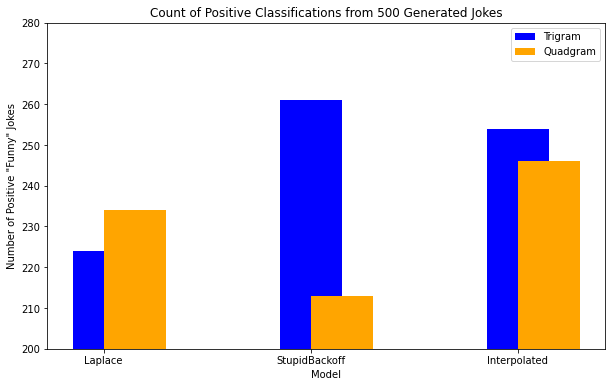

In [328]:
# graph each of the scores
plt.figure(figsize=(10, 6))
ax = plt.subplot(111)
ax.set_ylim(200, 280)
plt.title('Count of Positive Classifications from 500 Generated Jokes')
plt.xlabel('Model')
plt.ylabel('Number of Positive \"Funny\" Jokes')

labels = ['Laplace', 'StupidBackoff', 'Interpolated']
trigram_pos = [224, 261, 254]
quadgram_pos = [234, 213, 246]

ax.bar(labels, trigram_pos, width=0.3, color='b', align='center')
ax.bar(labels, bigram_pos, width=0.3, color='orange', align='edge')
ax.legend(['Trigram', 'Quadgram'])
plt.show()

Based on these raw counts, it can be seen that stupidbackoff smoothing with trigrams performed the best for this task. It produced 261/500 examples that were classified as funny or popular by the evaluation classifier. In second is the trigram absolute discounted interpolated model 254/500. And in third is the quadgram absolute discounted interpolated model 246/500. From these results it appears that increasing the order of ngrams did not provide a noteable increase in the scores, and in many cases actually resulted in a lower score. It can however be seen that smoothign does have a noteable effect on the generated sentences. The stupidbackoff and interpolated trigrams generated significantly more postively classified sentences than the laplace model.

A few examples of jokes generated by the top performing model.

In [122]:
positive_indices = [(i,v) for i, v in enumerate(score_quad_backoff) if v[1] > 0.55]
positive_examples = [(models[backoff_quad_lm][i[0]], i[1][1]) for i in positive_indices]

for (sentence, prob) in positive_examples:
    print(round(prob, 2), end=' ')
    displaySentence(sentence)
    print()

0.58 3 guys die and go to heaven. St. Peter says, “good lord! He’s done it again!"

0.55 A man goes to the eye doctor the doctor holds up a picture of a man.

0.72 After a long examination, the physicist yells: "Don't do it at home because he

0.66 A woman in the front seat." " O.K." Says the inventor, "You need to brush your

0.59 Only 50,000 bc kids will get this started with this gem this guy goes to talk to his professor

0.58 When i get naked in front of him, i will grant unto each of you take one

0.67 A blonde, brunette, and a paramedic are trying to find that his son started as a

0.72 What do you mean accidentally?!" Smith yells angrily. In a joking manner, the sergeant replies,

0.64 Schrödinger's cat walks into a hotel...... And god says 'stay'. The man says, "You can

0.58 My wife asked me to help her but she insisted. So the cashier put her finger into the box

0.58 Calling in sick today i called shotgun...And the cop sees him and pulls

0.57 A redditor walks into a bar an

### 7. Conclusion

From these highest scored sentences, the model is able to generate a few examples that do make sense, but also a few examples that are exactly from the training data such as this joke below. This joke was well recieved and the classifier is able to score it postively, predicting it will recieve more than 20 upvotes. The quadgram models are more likely to generate examples similar to training data. So the sentences generated to appear to make more sense, but are less unique and do score worse in the classifier than the trigram models.

**0.65 What's forest gumps password? 1Forest1** - Backoff Quadgram

Generating the exact same sentence from training is a very rare occurence and most of the sentences generated from all the models are completely unique. They still have their own challenges. Many of the jokes generate an end of sentence token despite really only generating one half of the joke and not the punchline. For example,

**How does harry potter go down a hill.** - Backoff Quadgram

And then other jokes where it does generate a punchline, but the puncline doesn't appear to make much sense.

**How do you catch a slutty bee? With a cowculator!!** - Backoff Trigram

**Why is oxygen like sex? A ginger-bread man** - Backoff Trigram




There is also a large subset of jokes from all the models which appear to be on track to generate a somewhat sensible joke, but haven't reach an end of sentence token and are cutoff before finishing, such as this example

**Three men approached the car. - Look pal," says the man. "Can i get big**

Since the sentences are cut off at 20 tokens some of them are unable to reach the end of sentence token in this time. This makes it difficult to evaluate the generation of longer sentences, but is necessary so that enough sentences could generated to compare the different smoothing methods.

#### Future Work
To expand on this it would be useful to evaluate also unigrams and bigrams, as well as more complex smoothing such as Kneser–Ney. The main preventing aspect are the resources required to generate sentences. Specifically, using NLTK Kneser-Ney was nearly impossible to generate sentences, even a single sentence was taking over 20 minutes of runtime. Therefore it could require looking for other packages or creating a specific implementation for this task. Using a larger dataset for training the language models would also be useful, but again would require more resources to train.

For the classifier it would be useful to look at not only score, but also score over time. I think it would be more useful to see which jokes gain popularity more quickly, versus ones that may have made it over 20 score, but over months or even years time. The dataset that I used didn't provide this information, so it would need to be gathered directly from the Reddit API. This could make the labeled data more accurately distinguish between good and bad jokes and improve the classifiers evaluation.

Another aspect that would be interesting to evaluate would be to seed the generation to start with the setup for a joke and then have the models generate the punchline. This could make comparing the resulting outputs more easy to interpret, but would require additional questions around what they should be seeded with and how this would impact the evaluation. Here are some examples seeded with **Why did the chicken cross the road?**


In [386]:
seed = ['<s>', 'Why' ,'did' ,'the' ,'chicken' ,'cross', 'the', 'road', '?']
print('Why did the chicken cross the road?')
for i in range(10):
    print(i, end=' ')
    displaySentence(ngram_generate_sentence(backoff_tri_lm, 20, seed))

Why did the chicken cross the road?
0 To get married. One night to remember. The boy h-how d-d-do i g-get t-to high st-street? The drummer.
1 To a service this week. See more @ fridayupdate on twitter.
2 To keep dora from exploring.
3 To go on go on the street."
4 To a part of the most intimate." The woman in the fence at the mail.
5 Buy the cat...Why does he go to the other motorist that she starts to come home drunk as
6 To get him together" The man replies "Sounds better when i see your nuts."
7 Because he could feel the pain. You should be the most beautiful woman, and decided to report that her
8 I'm fucking serious! I take my life. And then really takes it out of the church crowd. The
9 To get a divorce in heaven?" " How'd you like to keep this going to paint a


In [403]:
for i in range(10):
    print(i, end=' ')
    displaySentence(ngram_generate_sentence(backoff_quad_lm, 20, seed))

0 To go back to studying now. K bye.
1 To go with his new electric train in the living room playing scrabble."
2 To render the buildings on the other hand, you never told me what it is because you're really
3 The punchline is too long
4 To say hello from the other side
5 To knock knock on the door, his father stopped him and asked:" What do you call a
6 To say hello from the other side safely. Why? The alligators are at the oil refinery. One turns to
7 Because i've been trying to find him the perfect match: "I have been in business for 25
8 To say hello from the other half aren't very friendly there anyway!!!! And bangbangbangbang,
9 Because i put on some gloves. I'd like to get a closer look and lets out a little squeaker


#### References
- https://towardsdatascience.com/having-an-imbalanced-dataset-here-is-how-you-can-solve-it-1640568947eb
- https://textblob.readthedocs.io/en/dev/
- https://www.nltk.org/_modules/nltk/tokenize/treebank.html
- https://repository.lib.fit.edu/bitstream/handle/11141/682/ZHANG-THESIS.pdf?sequence=1&isAllowed=y
- https://web.stanford.edu/~jurafsky/slp3/